## Imports

In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git

In [6]:
!pip install catboost

In [7]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps

import statsmodels as sm

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

In [8]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

## Datasets

In [9]:
def calculate_offset_limit(offset, limit, length) -> tuple[int, int]:
    if offset is None:
      offset = 0
    else:
      offset = offset if offset >= 1 else int(offset * length)
    if limit is None:
      limit = length
    else:
      limit = limit if limit >= 1 else int(limit * length)
    return offset, limit

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
columns = {
    3: 'frameError',
    16: 'ema_est',
    17: 'ema_f_ec',
    19: 'vema_est',
    20: 'vema_f_ec',
    22: 'ml_est',
    23: 'ml_f_ec',
    25: 'phys_est',
    26: 'phys_f_ec',
}

data = pl.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_12-03.csv', has_header=False)
data = data[:, [k-1 for k in columns.keys()]]

data.columns = list(columns.values())
data = data.with_columns(
    pl.col('vema_f_ec').cast(float).alias('vema_f_ec'),
    pl.col('phys_f_ec').cast(float).alias('phys_f_ec'),
    pl.col('ema_f_ec').cast(float).alias('ema_f_ec'),
    pl.col('ml_f_ec').cast(float).alias('ml_f_ec'),
    pl.col('frameError').alias('qber'),
    (pl.col('frameError') - pl.col('ml_est')).abs().alias('ml_err'),
    (pl.col('frameError') - pl.col('ema_est')).abs().alias('ema_err'),
    (pl.col('frameError') - pl.col('vema_est')).abs().alias('vema_err'),
    (pl.col('frameError') - pl.col('phys_est')).abs().alias('phys_err'),
)
ts = data['qber']
ema_ts = data['ema_est']

In [12]:
def build_from_series(
    data: pl.Series,
    window_size: int,
    dtype: np.dtype = np.float32,
    offset: int | float = None,
    limit: int | float = None) -> tuple[np.ndarray, np.ndarray]:
    length = len(data)
    offset, limit = calculate_offset_limit(offset, limit, length)
    data = data.slice(offset, limit)
    data_array = data.to_numpy()
    dataset = np.lib.stride_tricks.sliding_window_view(
        data_array,
        window_size + 1,
        axis=0
        )
    return dataset

In [13]:
train_data = build_from_series(data=ts, window_size=30, limit=0.75)
test_data = build_from_series(data=ts, window_size=30, offset=0.75)

train_x, train_y = train_data[:, :-1], train_data[:, -1]
test_x, test_y = test_data[:, :-1], test_data[:, -1]

full_data = build_from_series(data=ts, window_size=30)
X, y = full_data[:, :-1], full_data[:, -1]

## Models

In [14]:
class ExponentionalAverager:
    def __init__(self, start_value, window_size):
        assert window_size >= 0
        self.val = start_value
        self.alpha = 2. / (window_size + 1)
        self.window_size = window_size

    def add_value(self, val):
        self.val = self.alpha * val + (1. - self.alpha) * self.val

    def get_value(self):
        return self.val

In [15]:
model = ExponentionalAverager(0.02, 5)
train_preds = []
test_preds = []

for val in train_y:
    train_preds.append(model.get_value())
    model.add_value(val)

for val in test_y:
    test_preds.append(model.get_value())
    model.add_value(val)


print('ExponentialAverager')
print(f'train R2 = {r2_score(train_y, train_preds):.7f}')
print(f'test R2 = {r2_score(test_y, test_preds):.7f}')
print(f'train MSE = {mean_squared_error(train_y, train_preds):.7f}')
print(f'test MSE = {mean_squared_error(test_y, test_preds):.7f}')
print(f'train RMSE = {mean_squared_error(train_y, train_preds, squared=False):.7f}')
print(f'test RMSE = {mean_squared_error(test_y, test_preds, squared=False):.7f}')
print('-' * 60)

ExponentialAverager
train R2 = 0.3460131
test R2 = 0.4379514
train MSE = 0.0000284
test MSE = 0.0000290
train RMSE = 0.0053303
test RMSE = 0.0053894
------------------------------------------------------------


In [1]:
import joblib

In [16]:
class CompositeModel(RegressorMixin, BaseEstimator):
    def __init__(self, boost_type: str = 'lgb'):
        super().__init__()
        self.base = LinearRegression()
        self.boost_type = boost_type
        assert self.boost_type in ('lgb', 'cb')
        if self.boost_type == 'lgb':
            self.boost = LGBMRegressor(verbose=-1)
        elif self.boost_type == 'cb':
            self.boost = CatBoostRegressor(verbose=False)

    def fit(self, X, y):
        self.base.fit(X, y)
        predictions = self.base.predict(X)
        diff = y - predictions
        self.boost.fit(X, diff)

    def predict(self, X):
        return self.base.predict(X) + self.boost.predict(X)

In [17]:
class EMACompositeModel(RegressorMixin, BaseEstimator):
    def __init__(self,
                 alpha: float = 1/2,
                 window_size: int = 30,
                 ) -> None:
        super().__init__()
        self.linear = None
        self.alpha = alpha
        self.window_size = window_size
        self.boost = LGBMRegressor(verbose=-1)

    def fit(self, X, y):
        self.linear = np.array(
            [self.alpha * (1 - self.alpha) ** i for i in range(self.window_size)]
        )[::-1]
        X = X[:, -self.window_size:]
        predictions = X @ self.linear
        diff = y - predictions
        self.boost.fit(X, diff)

    def predict(self, X):
        X = X[:, -self.window_size:]
        return X @ self.linear + self.boost.predict(X)

    def save(self, path_prefix: str):
        linear_filename = path_prefix + '_linear_model.joblib'
        joblib.dump(self.linear, open(linear_filename, "wb"))
        boost_filename = path_prefix + '_boost_model.joblib'
        joblib.dump(self.boost, open(boost_filename, "wb"))

    def load(self, path_prefix: str):
        linear_filename = path_prefix + '_linear_model.joblib'
        self.linear = joblib.load(linear_filename)
        self.alpha = self.linear[-1]
        boost_filename = path_prefix + '_boost_model.joblib'
        self.boost = joblib.load(boost_filename)

In [18]:
def evaluate_model(model):
    tscv = TimeSeriesSplit(n_splits=5)
    cv_res = cross_validate(
        model, X, y,
        scoring=['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
        cv=tscv
        )
    print(f'R2 by split: {cv_res["test_r2"]}')
    print(f'MSE by split: {-cv_res["test_neg_mean_squared_error"]}')
    model.fit(train_x, train_y)
    train_preds = model.predict(train_x)
    test_preds = model.predict(test_x)
    print(f'train R2 = {r2_score(train_y, train_preds):.7f}')
    print(f'test R2 = {r2_score(test_y, test_preds):.7f}')
    print(f'train MSE = {mean_squared_error(train_y, train_preds):.7f}')
    print(f'test MSE = {mean_squared_error(test_y, test_preds):.7f}')
    print(f'train RMSE = {mean_squared_error(train_y, train_preds, squared=False):.7f}')
    print(f'test RMSE = {mean_squared_error(test_y, test_preds, squared=False):.7f}')
    print('-' * 60)

In [3]:
evaluate_model(CompositeModel('lgb'))

NameError: name 'evaluate_model' is not defined

In [4]:
evaluate_model(EMACompositeModel(window_size=7))

NameError: name 'evaluate_model' is not defined

In [19]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA

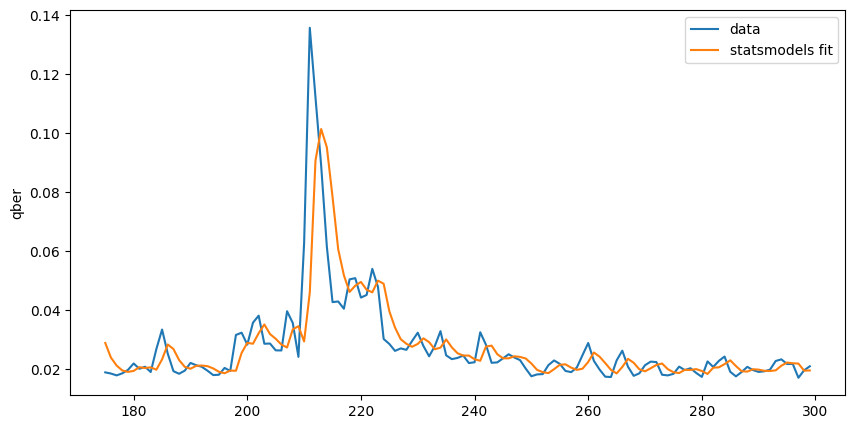

R2 = 0.3970736
MSE = 0.0000283
RMSE = 0.0053193
------------------------------------------------------------


In [107]:
ts_series = ts.to_pandas()

model = ETSModel(ts_series)
fit = model.fit(maxiter=10000)
plt.figure(figsize=(10, 5))
sns.lineplot(ts_series[175:300], label='data')

preds = fit.fittedvalues
preds[175:300].plot(label="statsmodels fit")

plt.legend()
plt.show()

print(model)
print(f'R2 = {r2_score(ts_series, preds):.7f}')
print(f'MSE = {mean_squared_error(ts_series, preds):.7f}')
print(f'RMSE = {mean_squared_error(ts_series, preds, squared=False):.7f}')
print('-' * 60)

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

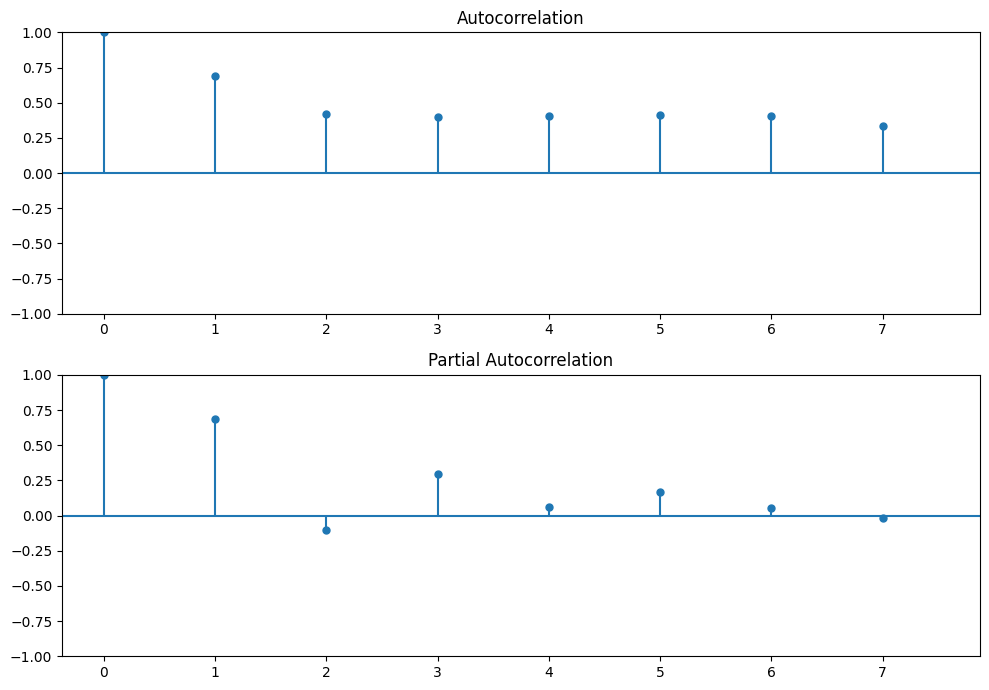

In [21]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
plot_acf(ts, lags=7, ax=ax[0])
plot_pacf(ts, lags=7, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

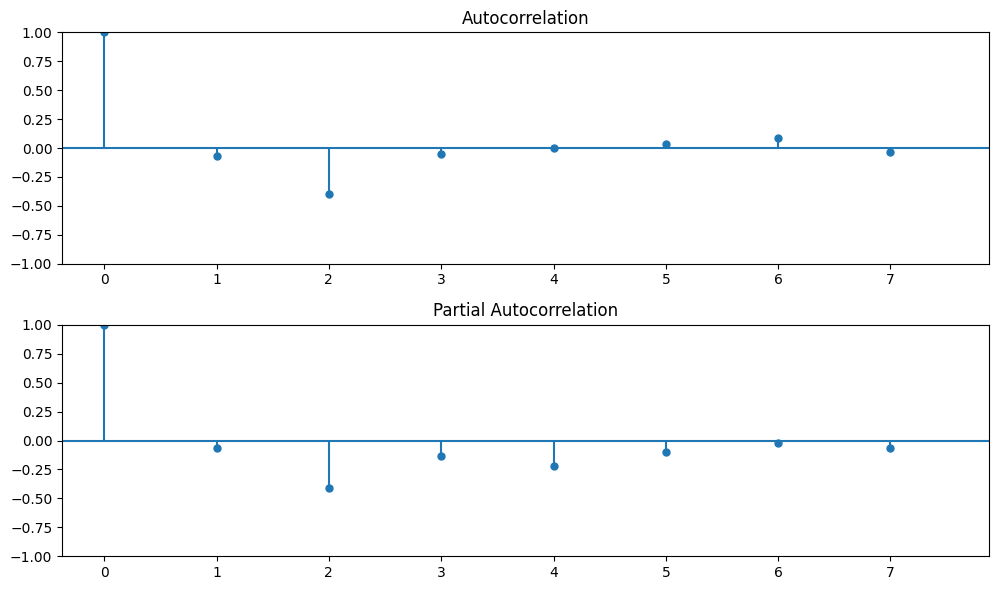

In [38]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
plot_acf(ts.diff()[1:], lags=7, ax=ax[0])
plot_pacf(ts.diff()[1:], lags=7, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

In [40]:
ts_series = ts.to_pandas()
diffed_ts = ts_series.diff()[1:]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


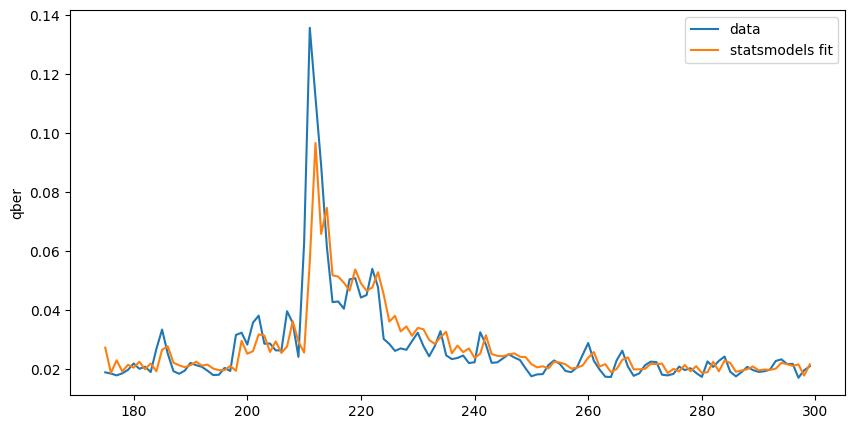

R2 = 0.5336023
MSE = 0.0000219
RMSE = 0.0046784
------------------------------------------------------------


In [42]:
model = ARIMA(ts_series, order=(1, 0, 2))
fit = model.fit()
plt.figure(figsize=(10, 5))
sns.lineplot(ts_series[175:300], label='data')

preds = fit.fittedvalues
preds[175:300].plot(label="statsmodels fit")

plt.legend()
plt.show()

print(model)
print(f'R2 = {r2_score(ts_series, preds):.7f}')
print(f'MSE = {mean_squared_error(ts_series, preds):.7f}')
print(f'RMSE = {mean_squared_error(ts_series, preds, squared=False):.7f}')
print('-' * 60)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


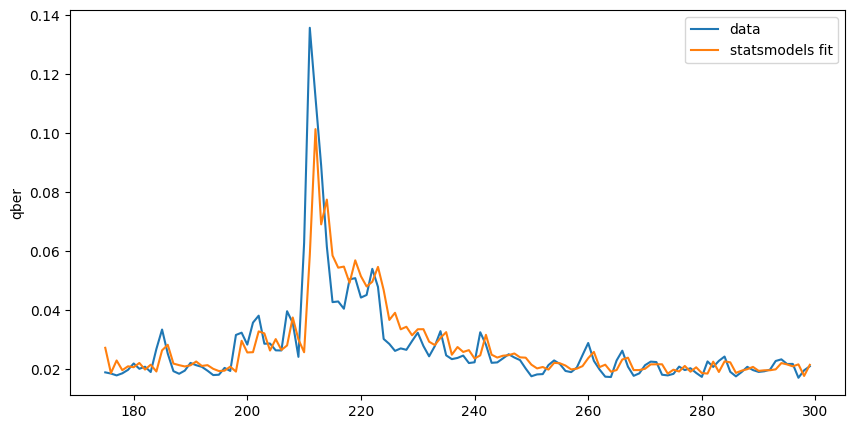

R2 = 0.5285231
MSE = 0.0000221
RMSE = 0.0047038
------------------------------------------------------------


In [43]:
model = ARIMA(ts_series, order=(2, 1, 2))
fit = model.fit()
plt.figure(figsize=(10, 5))
sns.lineplot(ts_series[175:300], label='data')

preds = fit.fittedvalues
preds[175:300].plot(label="statsmodels fit")

plt.legend()
plt.show()

print(model)
print(f'R2 = {r2_score(ts_series, preds):.7f}')
print(f'MSE = {mean_squared_error(ts_series, preds):.7f}')
print(f'RMSE = {mean_squared_error(ts_series, preds, squared=False):.7f}')
print('-' * 60)

In [44]:
class ExponentionalAverager:
    def __init__(self, start_value, alpha):
        self.val = start_value
        self.alpha = alpha

    def add_value(self, val):
        self.val = self.alpha * val + (1. - self.alpha) * self.val

    def get_value(self):
        return self.val

best_score = 0
best_ws = None

for ws in np.arange(0, 1, 0.05):
    model = ExponentionalAverager(0.02, ws)
    preds = []

    for val in ts:
        preds.append(model.get_value())
        model.add_value(val)

    score = r2_score(ts, preds)
    if score > best_score:
        best_score = score
        best_ws = ws

model = ExponentionalAverager(0.02, best_ws)
preds = []

for val in ts:
    preds.append(model.get_value())
    model.add_value(val)

print(f'Window size = {best_ws}')
print(f'R2 = {r2_score(ts, preds):.7f}')
print(f'MSE = {mean_squared_error(ts, preds):.7f}')
print(f'RMSE = {mean_squared_error(ts, preds, squared=False):.7f}')
print('-' * 60)

Window size = 0.5
R2 = 0.3970725
MSE = 0.0000283
RMSE = 0.0053193
------------------------------------------------------------


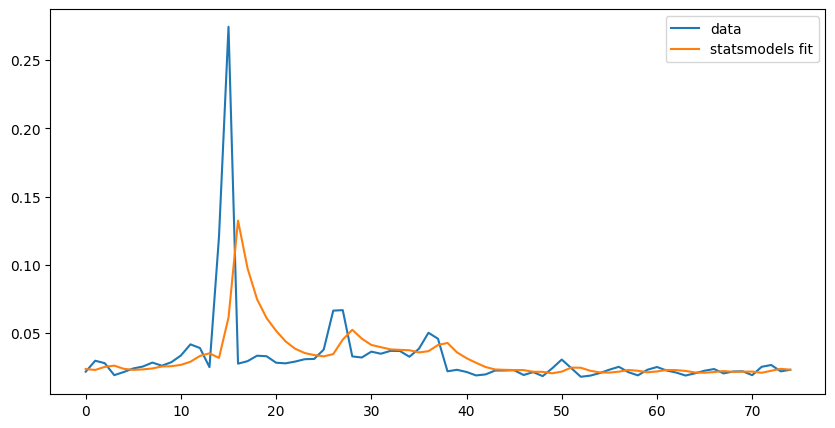

R2 = 0.4379436
MSE = 0.0000290
RMSE = 0.0053894


In [45]:
model = ExponentionalAverager(0.02, alpha=1/3)
preds = []

for val in test_y:
    preds.append(model.get_value())
    model.add_value(val)

plt.figure(figsize=(10, 5))
sns.lineplot(test_y[1000:1075], label='data')
sns.lineplot(preds[1000:1075], label='statsmodels fit')

plt.legend()
plt.show()

print(f'R2 = {r2_score(test_y, preds):.7f}')
print(f'MSE = {mean_squared_error(test_y, preds):.7f}')
print(f'RMSE = {mean_squared_error(test_y, preds, squared=False):.7f}')

In [46]:
model = EMACompositeModel(alpha=1/3, window_size=7)
model.fit(train_x, train_y)
preds = model.predict(test_x)

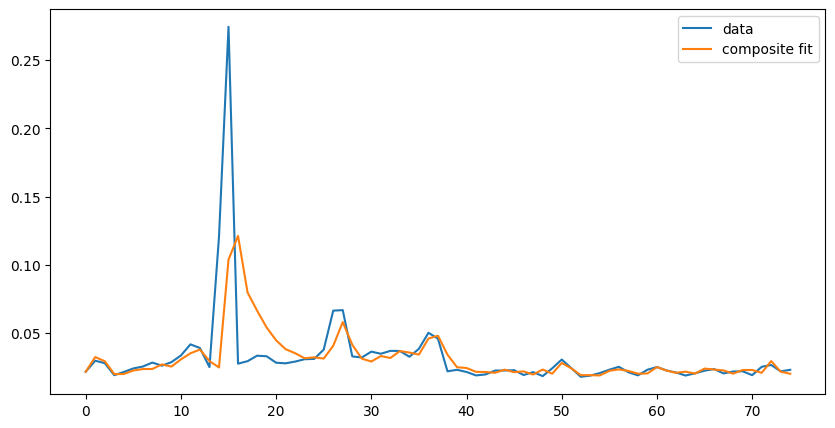

R2 = 0.6193738
MSE = 0.0000197
RMSE = 0.0044351


In [47]:
plt.figure(figsize=(10, 5))
sns.lineplot(test_y[1000:1075], label='data')
sns.lineplot(preds[1000:1075], label='composite fit')

plt.legend()
plt.show()

print(f'R2 = {r2_score(test_y, preds):.7f}')
print(f'MSE = {mean_squared_error(test_y, preds):.7f}')
print(f'RMSE = {mean_squared_error(test_y, preds, squared=False):.7f}')

# Results
Meh, ARIMA and ARMA still worse than LGBM + ETS!
But that is true when data domain is same for train and test, I guess. Not sure if it will be the same on new experiments :-)